**Whisper**

Whisper is a pre-trained model for automatic speech recognition (ASR) and speech translation.

Whisper is a Transformer based encoder-decoder model, also referred to as a sequence-to-sequence model. It was trained on 680k hours of labelled speech data annotated using large-scale weak supervision.

**SUMMARY OF THE PROCESS**

Initially, the **Ai4 Bharat Indic Wav2Vec** speech recognition model was
employed to transcribe Hindi audio. This model yielded an accuracy of 60%, which necessitated exploring more robust alternatives. Subsequently, the **OpenAI Whisper model (small version)** was tested, achieving a slightly better accuracy of **65%**. Recognizing the potential for improvement, the Whisper model was **fine-tuned on the Common Voice dataset**. After 1000 steps of training, the model's word error rate (WER) improved to 34%. Extending the training to 2000 steps resulted in a WER of 32%.

The pursuit of higher accuracy led to the decision to fine-tune the **OpenAI Whisper medium model** specifically for the Hindi language using the **Google Fleurs dataset,** which is better as compared to the Common Voice dataset. This fine-tuning process, conducted over 1000 steps, significantly reduced the WER to 20%.

Furthermore, the **Whisper English model** was tested on Republic TV audio. Remarkably, it performed exceptionally well without any fine-tuning, achieving **99% accuracy**. The model also adeptly inserted punctuation, enhancing the readability and coherence of the transcripts.



In [ ]:

!pip install --upgrade datasets[audio] transformers accelerate evaluate jiwer tensorboard


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 54.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 87.6 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 29.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.3/401.3 kB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 37.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 63.8 MB/s eta 0:00:00:00:01
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.1
    Uninstalling tensorboard-2.15.1:
      Successfully uninstalled tensorboard-2.15.1
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface

In [ ]:
from huggingface_hub import notebook_login

notebook_login()


Using 🤗 Datasets, downloading and preparing data is extremely simple. We’ll use Google Fleurs dataset.
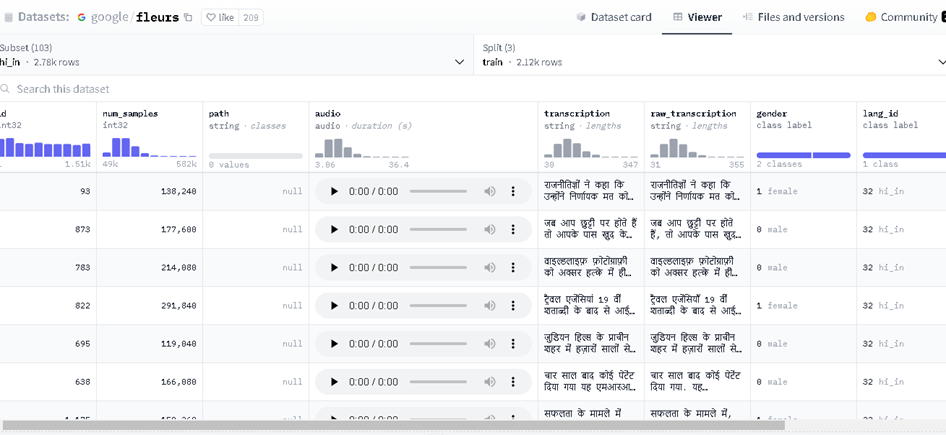

In [ ]:
from datasets import load_dataset, DatasetDict

fleurs = DatasetDict()

fleurs["train"] = load_dataset("google/fleurs", "hi_in", split="train+validation", use_auth_token=True)
fleurs["test"] = load_dataset("google/fleurs", "hi_in", split="test", use_auth_token=True)

print(fleurs)


/opt/conda/lib/python3.10/site-packages/datasets/load.py:2547: FutureWarning: 'use_auth_token' was deprecated in favor of 'token' in version 2.14.0 and will be removed in 3.0.0.
You can remove this warning by passing 'token=<use_auth_token>' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/datasets/load.py:1486: FutureWarning: The repository for google/fleurs contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/google/fleurs
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

/opt/conda/lib/python3.10/site-packages/datasets/load.py:2547: FutureWarning: 'use_auth_token' was deprecated in favor of 'token' in version 2.14.0 and will be removed in 3.0.0.
You can remove this warning by passing 'token=<use_auth_token>' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/datasets/load.py:1486: FutureWarning: The repository for google/fleurs contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/google/fleurs
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


DatasetDict({
    train: Dataset({
        features: ['id', 'num_samples', 'path', 'audio', 'transcription', 'raw_transcription', 'gender', 'lang_id', 'language', 'lang_group_id'],
        num_rows: 2359
    })
    test: Dataset({
        features: ['id', 'num_samples', 'path', 'audio', 'transcription', 'raw_transcription', 'gender', 'lang_id', 'language', 'lang_group_id'],
        num_rows: 418
    })
})


In [ ]:
fleurs = fleurs.remove_columns(["id", "num_samples" , "path", "raw_transcription" , "gender" , "lang_id" , "language" , "lang_group_id"])


The ASR pipeline can be de-composed into three stages:
1. A feature extractor which pre-processes the raw audio-inputs
2. The model which performs the sequence-to-sequence mapping
3. A tokenizer which post-processes the model outputs to text format


In [ ]:
from transformers import WhisperFeatureExtractor

feature_extractor = WhisperFeatureExtractor.from_pretrained("openai/whisper-medium")


preprocessor_config.json:   0%|          | 0.00/185k [00:00<?, ?B/s]

In [ ]:
from transformers import WhisperTokenizer

tokenizer = WhisperTokenizer.from_pretrained("openai/whisper-medium", language="Hindi", task="transcribe")


tokenizer_config.json:   0%|          | 0.00/283k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/836k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.48M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/494k [00:00<?, ?B/s]

normalizer.json:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.19k [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
input_str = fleurs["train"][0]["transcription"]
labels = tokenizer(input_str).input_ids
decoded_with_special = tokenizer.decode(labels, skip_special_tokens=False)
decoded_str = tokenizer.decode(labels, skip_special_tokens=True)

print(f"Input:                 {input_str}")
print(f"Decoded w/ special:    {decoded_with_special}")
print(f"Decoded w/out special: {decoded_str}")
print(f"Are equal:             {input_str == decoded_str}")


2024-05-24 11:31:20.004299: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-24 11:31:20.004414: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-24 11:31:20.147342: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Input:                 राजनीतिज्ञों ने कहा कि उन्होंने निर्णायक मत को अनावश्यक रूप से निर्धारित करने के लिए अफ़गान संविधान में काफी अस्पष्टता पाई थी
Decoded w/ special:    <|startoftranscript|><|hi|><|transcribe|><|notimestamps|>राजनीतिज्ञों ने कहा कि उन्होंने निर्णायक मत को अनावश्यक रूप से निर्धारित करने के लिए अफ़गान संविधान में काफी अस्पष्टता पाई थी<|endoftext|>
Decoded w/out special: राजनीतिज्ञों ने कहा कि उन्होंने निर्णायक मत को अनावश्यक रूप से निर्धारित करने के लिए अफ़गान संविधान में काफी अस्पष्टता पाई थी
Are equal:             True


In [ ]:
from transformers import WhisperProcessor

processor = WhisperProcessor.from_pretrained("openai/whisper-medium", language="Hindi", task="transcribe")


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
print(fleurs["train"][0])


{'audio': {'path': 'train/10002503286825416621.wav', 'array': array([ 0.        ,  0.        ,  0.        , ..., -0.00179154,
        0.0009104 , -0.00036222]), 'sampling_rate': 16000}, 'transcription': 'राजनीतिज्ञों ने कहा कि उन्होंने निर्णायक मत को अनावश्यक रूप से निर्धारित करने के लिए अफ़गान संविधान में काफी अस्पष्टता पाई थी'}


In [ ]:
from datasets import Audio

fleurs = fleurs.cast_column("audio", Audio(sampling_rate=16000))


In [ ]:
print(fleurs["train"][0])


{'audio': {'path': 'train/10002503286825416621.wav', 'array': array([ 0.        ,  0.        ,  0.        , ..., -0.00179154,
        0.0009104 , -0.00036222]), 'sampling_rate': 16000}, 'transcription': 'राजनीतिज्ञों ने कहा कि उन्होंने निर्णायक मत को अनावश्यक रूप से निर्धारित करने के लिए अफ़गान संविधान में काफी अस्पष्टता पाई थी'}


Now we can write a function to prepare our data ready for the model:

In [ ]:
def prepare_dataset(batch):
    # load and resample audio data from 48 to 16kHz
    audio = batch["audio"]

    # compute log-Mel input features from input audio array
    batch["input_features"] = feature_extractor(audio["array"], sampling_rate=audio["sampling_rate"]).input_features[0]

    # encode target text to label ids
    batch["labels"] = tokenizer(batch["transcription"]).input_ids
    return batch


In [ ]:
fleurs = fleurs.map(prepare_dataset, remove_columns=fleurs.column_names["train"], num_proc=2)


Map (num_proc=2):   0%|          | 0/2359 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/418 [00:00<?, ? examples/s]

We'll start our fine-tuning run from the pre-trained Whisper medium checkpoint. To do this, we'll load the pre-trained weights from the Hugging Face Hub.

In [ ]:
from transformers import WhisperForConditionalGeneration

model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-medium")


config.json:   0%|          | 0.00/1.99k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.06G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/3.75k [00:00<?, ?B/s]

In [ ]:
model.generation_config.language = "hindi"
model.generation_config.task = "transcribe"

model.generation_config.forced_decoder_ids = None


In [ ]:
import torch

from dataclasses import dataclass
from typing import Any, Dict, List, Union

@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:
    processor: Any
    decoder_start_token_id: int

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lengths and need different padding methods
        # first treat the audio inputs by simply returning torch tensors
        input_features = [{"input_features": feature["input_features"]} for feature in features]
        batch = self.processor.feature_extractor.pad(input_features, return_tensors="pt")

        # get the tokenized label sequences
        label_features = [{"input_ids": feature["labels"]} for feature in features]
        # pad the labels to max length
        labels_batch = self.processor.tokenizer.pad(label_features, return_tensors="pt")

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        # if bos token is appended in previous tokenization step,
        # cut bos token here as it's append later anyways
        if (labels[:, 0] == self.decoder_start_token_id).all().cpu().item():
            labels = labels[:, 1:]

        batch["labels"] = labels

        return batch


The data collator for a sequence-to-sequence speech model is unique in the sense that it treats the input_features and labels independently: the input_features must be handled by the feature extractor and the labels by the tokenizer.

In [ ]:
data_collator = DataCollatorSpeechSeq2SeqWithPadding(
    processor=processor,
    decoder_start_token_id=model.config.decoder_start_token_id,
)


We'll use the word error rate (WER) metric, the 'de-facto' metric for assessing ASR systems. For more information, refer to the WER docs. We'll load the WER metric from 🤗 Evaluate:

In [ ]:
import evaluate

metric = evaluate.load("wer")


In [ ]:
def compute_metrics(pred):
    pred_ids = pred.predictions
    label_ids = pred.label_ids

    # replace -100 with the pad_token_id
    label_ids[label_ids == -100] = tokenizer.pad_token_id

    # we do not want to group tokens when computing the metrics
    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    label_str = tokenizer.batch_decode(label_ids, skip_special_tokens=True)

    wer = 100 * metric.compute(predictions=pred_str, references=label_str)

    return {"wer": wer}


We'll train the model for 1000 steps saving every 250 steps.

In [ ]:
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    output_dir="./whisper-medium-hindi",  # change to a repo name of your choice
    per_device_train_batch_size=4,
    gradient_accumulation_steps=2,  # increase by 2x for every 2x decrease in batch size
    learning_rate=1e-5,
    warmup_steps=250,
    max_steps=1000,
    gradient_checkpointing=True,
    fp16=True,
    evaluation_strategy="steps",
    per_device_eval_batch_size=4,
    predict_with_generate=True,
    generation_max_length=225,
    save_steps=1000,
    eval_steps=250,
    logging_steps=25,
    report_to=["tensorboard"],
    load_best_model_at_end=True,
    metric_for_best_model="wer",
    greater_is_better=False,
    push_to_hub=True,
)


/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=fleurs["train"],
    eval_dataset=fleurs["test"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=processor.feature_extractor,
)


max_steps is given, it will override any value given in num_train_epochs


In [ ]:
trainer.train()


**OUTPUT:**

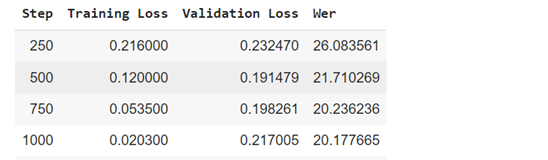

In [ ]:
trainer.push_to_hub(**kwargs)

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 448, 'suppress_tokens': [1, 2, 7, 8, 9, 10, 14, 25, 26, 27, 28, 29, 31, 58, 59, 60, 61, 62, 63, 90, 91, 92, 93, 359, 503, 522, 542, 873, 893, 902, 918, 922, 931, 1350, 1853, 1982, 2460, 2627, 3246, 3253, 3268, 3536, 3846, 3961, 4183, 4667, 6585, 6647, 7273, 9061, 9383, 10428, 10929, 11938, 12033, 12331, 12562, 13793, 14157, 14635, 15265, 15618, 16553, 16604, 18362, 18956, 20075, 21675, 22520, 26130, 26161, 26435, 28279, 29464, 31650, 32302, 32470, 36865, 42863, 47425, 49870, 50254, 50258, 50358, 50359, 50360, 50361, 50362], 'begin_suppress_tokens': [220, 50257]}


events.out.tfevents.1716550571.ae12092f17cd.35.0:   0%|          | 0.00/26.0k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.06G [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

CommitInfo(commit_url='https://huggingface.co/Tashuu/whisper-medium-hindi/commit/e842ff6d43d54ea03c8397a572049d288539aa1e', commit_message='End of training', commit_description='', oid='e842ff6d43d54ea03c8397a572049d288539aa1e', pr_url=None, pr_revision=None, pr_num=None)

Tokenizer is not pushed automatically to the hugging face hub, so we need to push the tokenizer:

In [ ]:
tokenizer.push_to_hub("Tashuu/whisper-medium-hindi")

README.md:   0%|          | 0.00/1.50k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Tashuu/whisper-medium-hindi/commit/7ae3566f21850e0b2f3824a942568f150f3998f6', commit_message='Upload tokenizer', commit_description='', oid='7ae3566f21850e0b2f3824a942568f150f3998f6', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
kwargs = {
    "dataset_tags": "mozilla-foundation/common_voice_11_0",
    "dataset": "Common Voice 11.0",  # a 'pretty' name for the training dataset
    "dataset_args": "config: hi, split: test",
    "language": "hi",
    "model_name": "Whisper Medium hindi -tashu gurnani",  # a 'pretty' name for your model
    "finetuned_from": "openai/whisper-small",
    "tasks": "automatic-speech-recognition",
}


Here is the link to the finetuned Whisper Hindi (Medium) model pushed to the hub:
https://huggingface.co/Tashuu/whisper-medium-hindi/commit/e842ff6d43d54ea03c8397a572049d288539aa1e


Now , for a practice run, to verify our model works as expected

In [ ]:
from transformers import pipeline
pipe = pipeline(model="Tashuu/whisper-medium-hindi")

2024-05-25 18:17:45.461680: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-25 18:17:45.461808: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-25 18:17:45.607284: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


config.json:   0%|          | 0.00/2.28k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.06G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/3.70k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/283k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/494k [00:00<?, ?B/s]

normalizer.json:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.19k [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


preprocessor_config.json:   0%|          | 0.00/339 [00:00<?, ?B/s]

In [ ]:
def transcribe(audio):
    text = pipe(audio)["text"]
    return text

In [ ]:
transcribe("/kaggle/input/finaltesting5/audio (1).mp3")

'आगरा में मंगलवार रात करीब 10 बजे माल रोड पर चलती हुई कार में अचानक आग लग गई कार सवार ने कूदकर अपनी जान बचाई सूचना पर पहुंची फायर ब्रिगेट की गाड़ी जब तक आग बुझाती कार पूरी तरह से जल चुकी थी कार में आग लगने की वजह शॉर्ट सर्किट बताया गया है'

In [ ]:
transcribe("/kaggle/input/finaltesting2/AAJ TAK_2024-02-17_08-00-00 (mp3cut.net) (4).wav")

'आज हर्याना के हर तशील में किसान निकालेंगे ट्रैक्टर परेट और चंडीघर में बड़े बीज़ेपी नेताओं की घरों के घिराव कायलाएंसंदेशकाली में राज्यपाल से मिलने के बाद कोट जाने की तैयारी में बीज़ेपी ग्रह राज्य मंत्री बोले ममता से नहीं समल रहा तो केंद्र लेगा फैसलाआज से देली में बीज़ेपी राष्ट्रीय काउंसल की बैठक लगभग 11,000 प्रतिरिधी होंगे शामिल ज़ेफ़ी नड़ा करेंगे बैठक का उद्घाटनईडीय समन के देखी मामली में आज देली की कोट में सीएम केज़रवाल की पेशी पांच समन छुकराने के बाद ईडी ने किया था अदालत का रुकऔर आज से दो दिदो तक कुल्काथा में सजेगा साहित्य आज तक का मंच गीत संगीत शायरी से लेकर नज्म नाठकों के महाकुंबद में जूटेंगे तमाम सितारें आपका भी स्वागत एंट्री फ़्री'

Denoising the audio through demucs model. The denoised audio will be saved to the separated folder and vocals.wav file can then be passed to whisper model to generate transcription.

**AUDIO TRANSCRIPTION FOR ENGLISH LANGUAGE**

The first step is to import the required libraries. We are using the pipeline function from the transformers library to load the Whisper model. We initialize the transcription pipeline using the Whisper model. The **openai/whisper-medium.en** model is specifically designed for English audio transcription. We define a function transcribe that takes an audio file path as input, uses the pipeline to transcribe the audio, and returns the transcribed text. Finally, we call the transcribe function with the path to an audio file.  


In [ ]:
from transformers import pipeline
pipe = pipeline(model="openai/whisper-medium.en")

# Function to transcribe audio chunk
def transcribe(file):
    text = pipe(file)["text"]
    return text

2024-06-05 06:16:56.751638: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-05 06:16:56.751748: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-05 06:16:56.873389: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


config.json:   0%|          | 0.00/1.95k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.06G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/1.95k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/805 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.41M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

normalizer.json:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.83k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/185k [00:00<?, ?B/s]

In [ ]:
transcribe("/kaggle/input/testing2min/RepubAudio 1(1).mp3")

" a promising development for all. BJP wakes up Mahadev scam to slam Congress says Congress is neck deep in corruption. Israel Defense Forces encircle Al Shifa hospital, intensify ground operations with underground Hamas headquarters on the target. Israel's multi-front war against terror continues with the fight against Hamas as well as Hezbollah terrorists. The Republic has been on the ground getting new minute by minute updates as far as Israeli forces operations are concerned. Gursimran is in fact joining us live. He is reporting from southern Israel and if Gursimran can hear my question, Gursimran all eyes are on actually on Al-Shifa in Gaza where the operations are intensifying, the ground operations are intensifying. The sole target of the Israeli forces is to take aim at the alleged Hamas headquarters that is believed to be in the basement of this hospital. What are you gathering from your sources in the Israeli military as to how is this operation proceeding. See the operation 